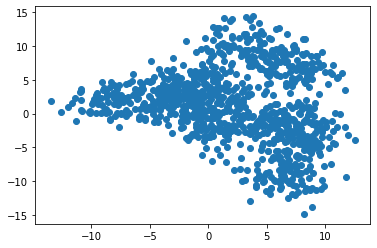

In [1]:
# 実装

# ライブラリimport
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# data用意
X, y = make_blobs(n_samples=1000, centers=10, cluster_std=2, n_features=2,random_state=6)

# data可視化

plt.scatter(X[:,0], X[:,1])




In [8]:

from sklearn.cluster import KMeans

# 各種パラメータ定義


# load function

def load(points, alpha):
    variance = np.var(points, axis=0) # o(n)
    return alpha * points.shape[0] + (1-alpha) * np.linalg.norm(variance)

# k-means 1の方法
def kload(data, alpha=0.5,k=2, criteria=1.5, max_iter=10):
    kmeans = KMeans(n_clusters=k).fit(data)
    
    labels = kmeans.labels_
    inertia = kmeans.inertia_
    centers = kmeans.cluster_centers_
    
    # print(centers)
    
    
    iter_count = 0
    while True: 
        iter_count += 1
        
        # クラスタ再配置 based on load func
        clusters = np.array([ data[labels==j] for j in range(0,k)])
        loads = np.array([load(cluster, alpha) for cluster in clusters])
        # print("loads", loads)

        # ロードの計算
        max_cluster_idx = np.argmax(loads)
        min_cluster_idx = np.argmin(loads)
        max_load = np.max(loads)
        min_load = np.min(loads)
        delta_load = max_load / min_load
        
        if (delta_load < criteria) | (max_iter < iter_count):
            break
        

#       最大ロードのクラスタから一番外側の点を探す
        
        all_norms = np.linalg.norm(data - centers[max_cluster_idx], axis=1)
        idxs = np.array(np.where(labels == max_cluster_idx)).flatten()
        child_idx = np.argmax(all_norms[idxs])
        outmost_idx = idxs[child_idx]
    
        # 所属クラスタを除く一番近いクラスタに配置
        # 一番近いクラスタを探す
        # print('cluster dist', np.linalg.norm(centers - data[outmost_idx], axis=1))
        
        centers_wo_belong = np.copy(centers)
        centers_wo_belong[max_cluster_idx] = np.full(data.shape[1], np.inf)
        
        # print(' centers_wo_belong', centers_wo_belong, data[outmost_idx])
        nearest_cluster_idx = np.argmin(np.linalg.norm(centers_wo_belong - data[outmost_idx], axis=1))
        # print('nearest cluster idx', nearest_cluster_idx)
        
        # 所属クラスタを変更
        
        # print(labels[outmost_idx])


        labels[outmost_idx] = nearest_cluster_idx
        
        # print(labels[outmost_idx])
        
        # delta_load = 1
        
        print(max_cluster_idx, delta_load, max_load, min_load)
        


        
    
    
    return


kload(data=X, alpha=0.2, k=5 )

print()


# 評価. 可視化、ロードの分散具合、計算量、
# k, alpha, データ数, 次元数を変えてみて

# 発展
# ロード関数を変えれば、重みつきのデータにも対応。
# クラスタ入れ替え時に、一つではなくbulkでもいい



4 2.3108520937806096 68.02893934223067 29.43889811265839
4 2.2691406990921865 67.74835586644407 29.856392727673565
4 2.2604520066750635 67.48894285334849 29.856392727673565
4 2.2518078304990894 67.2308589346314 29.856392727673565
4 2.2434207639421633 66.98045138167468 29.856392727673565
4 2.2349255523217404 66.72681500723064 29.856392727673565
4 2.226332485529367 66.47025703034241 29.856392727673565
4 2.218080966360321 66.22389643343145 29.856392727673565
4 2.2109043385676053 66.00962821559179 29.856392727673565
4 2.2027714970576735 65.76681090547933 29.856392727673565



/tmp/ipykernel_9857/3357962582.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clusters = np.array([ data[labels==j] for j in range(0,k)])


In [126]:
# 2. k-meansの距離関数を、ロードの差関数に変更。
# k-means自体のアルゴリズムを拡張
import itertools 

# load function
def load(num, alpha, variance):
    return alpha * num + (1-alpha) * np.linalg.norm(variance)

# load delta
def load_delta(num, alpha, node, variance, mean):
    vec = alpha + (1-alpha) * 1/(num+1) * ( num * (np.square(mean) - mean) + np.square(node) + node - variance )

    return np.linalg.norm(vec)

def kload2(data, alpha=0.5,k=4, max_iter=10,random_seed=1):
    #指定したクラスター数分のラベルを繰り返し作成するジェネレータを生成（0,1,2,0,1,2,0,1,2...みたいな感じ
    cycle = itertools.cycle(range(k))
    #各データポイントに対してクラスタのラベルをランダムに割り振る
    labels = np.fromiter(itertools.islice(cycle, data.shape[0]), dtype = int)
    random_state = np.random.RandomState(random_seed)
    random_state.shuffle(labels)
    
    labels_prev = np.zeros(data.shape[0])
    count = 0
    cluster_centers = np.zeros((k, data.shape[1]))
    variances = np.zeros((k, data.shape[1]))
    cluster_sizes = np.zeros(k)
    loads = np.zeros(k)
    
    # クラスタの変化がない、or 最大回数
    while (not np.array_equal(labels, labels_prev) and (count < max_iter)):
        # 判定用変数
        labels_prev = labels.copy()
        count += 1
        
        #その時点での各クラスターの重心を計算する

        
        for j in range(k):
            cluster_nodes = data[labels == j, :]
            cluster_sizes[j] = cluster_nodes.shape[0]
            if cluster_sizes[j] == 0:
                variances[j, :] = 0
                cluster_centers[j, :] = 0
            else:
                variances[j, :] = np.nanvar(cluster_nodes, axis=0)
                cluster_centers[j, :] = np.nanmean(cluster_nodes, axis = 0)
            loads[j] = load(cluster_sizes[j], alpha, variances[j])
            
        #各データポイントと各クラスターの重心間の距離を総当たりで計算する
        
        for i, x in enumerate(data):
            deltas = np.zeros(k)
            for j in range(k):
                m = cluster_sizes[j]
                
                # o(1) but 上手く行かない方
                deltas[j] = load_delta(m, alpha, x, variances[j], cluster_centers[j])
                
                # new_loa
                d o(n/k) 計算量爆発するし、収束しない
#                 cluster_nodes = data[labels == j, :]
#                 cluster_size = cluster_nodes.shape[0]
#                 variance = np.nanvar(cluster_nodes, axis=0)
                
#                 deltas[j] = load(cluster_size, alpha, variance)
        
            labels[i] = np.argmin(deltas)
            
        # print('cond', np.array_equal(labels, labels_prev), count<max_iter)
        # print(labels_prev[:10], labels[:10])
        # print(count)
        # print("v",variances)
        # print("c", cluster_centers)
        print("l",loads, np.sum(loads))
    # end while
    return labels, cluster_centers, loads

kload2(data=X[:1000], alpha=0.1, k=5, max_iter=30,random_seed=8)

l [59.52141927 58.19517769 54.80994582 55.74754331 54.01548759] 282.28957367576845
l [  0.         136.74293293   0.           0.           0.        ] 136.74293292520855
l [  5.40281285 133.64259071   0.           0.           0.        ] 139.04540355167836
l [102.80614201  94.56293888   1.98214729   0.           0.        ] 199.35122817674468
l [136.46396359   0.           0.           0.50528356   0.        ] 136.96924715336704
l [130.77021238   4.22743667   0.           7.59313541   0.        ] 142.5907844593224
l [92.63829219 88.36633975  1.98214729 68.37264338  0.        ] 251.35942260088717
l [  0.         136.39471003   0.           0.           0.58537501] 136.98008503485917
l [  4.22743667 130.33294332   0.           0.           8.49867472] 143.05905471621244
l [ 43.4836495  111.20132895   1.98214729   0.         103.40552919] 260.0726549227418
l [135.44533283   0.           0.           2.22232311   0.        ] 137.66765594381084
l [113.07602202   2.69047585   0.          4

(array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [15]:
np.zeros((5))

array([0., 0., 0., 0., 0.])

In [88]:
np.var([0])

0.0